In this notebook I will test the model proposed in the ensemble learning lecture.
Chapter with explenation about the algorithm behind the lightGBM, will write this after the coding.

LightGBM is good in our case because it can deal with categorical values. We will start with importing the data, the data is already divided into test and training data.

In [1]:
import lightgbm as lgb
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
plt.style.use('ggplot')

I want to use import_data function from another directory, and make the data ready for the model. LightGBM accepts categorical values, but they have to be encoded as no-negative integers.


inni
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   area_total          23285 non-null  float64 
 1   area_kitchen        23285 non-null  float64 
 2   area_living         23285 non-null  float64 
 3   floor               23285 non-null  float64 
 4   rooms               23285 non-null  float64 
 5   layout              23285 non-null  float64 
 6   ceiling             23285 non-null  float64 
 7   bathrooms_shared    23285 non-null  float64 
 8   bathrooms_private   23285 non-null  float64 
 9   windows_court       23285 non-null  float64 
 10  windows_street      23285 non-null  float64 
 11  balconies           23285 non-null  float64 
 12  loggias             23285 non-null  float64 
 13  condition           23285 non-null  float64 
 14  phones              23285 non-null  float64 
 15  building_id         23285 non-n

c:\Users\gunna\tdt4173-task-2\moscow_housing\venv\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


first run 0.1834119728836997


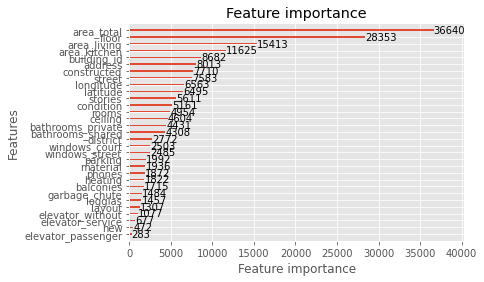

In [2]:
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../data')
from display_data import import_data

#We dont want our model to care about the id of the house or the seller
#In my first run, i will replace missing values with the mean value
data, data_test = import_data()
Y = data.price
data = data.drop(columns=['price','id','seller'])


for column in data.columns:
    column_type = data[column].dtype
    if column_type == 'object':
        break
    data[column] = data[column].replace(np.NaN, data[column].mean())

#turn categorical features into correct type
for column in data.columns:
    column_type = data[column].dtype
    if column_type == 'object':
        data[column] = data[column].astype('category')


X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)


def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

data.info()
print(len(Y))
print(data.corr())

lightGBM_model = lgb.LGBMRegressor(
    num_leaves=20,
    max_depth=15,
    random_state=42,
    silent=True,
    metric='mse',
    n_jobs=4,
    n_estimators=10000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.09)

lightGBM_model.fit(X_train,y_train)
prediction = lightGBM_model.predict(X_test)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        prediction[count] = prediction.mean()
    count += 1

rmsle = root_mean_squared_log_error(y_test,prediction)
print("first run", rmsle)





Second attempt

In [3]:
from sklearn.model_selection import train_test_split
from moscow_housing.display_data import import_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


#We dont want our model to care about the id of the house or the seller
#For my second run, i want to use linear regression to predict the missing values
data_2, data_test_2 = import_data()
Y_2 = data_2.price

data_2 = data_2.drop(columns=['id', 'seller','price'])

# we want to train the missing data on the price aswell, but then we have to split into testing and training data before we predict missing values.
# turn categorical features into correct type
for column in data_2.columns:
    column_type = data_2[column].dtype
    if column_type == 'object':
        data_2[column] = data_2[column].astype('category')

#splitting the data into test and train set
X_train, X_test, y_train, y_test = train_test_split(data_2, Y_2, test_size=0.2, random_state=42)

#splitting the data into data with or without nan
X_train_without_NaN = X_train[['street','address']]
X_train_with_NaN = X_train.drop(columns=['street','address'])
X_test_without_NaN = X_test[['street','address']]
X_test_with_NaN = X_test.drop(columns=['street','address'])

#add price to the train dataset to get better results
X_train_with_NaN['price'] = y_train

#train model and predict missing values, returns an numpy array
imp_mean_train = IterativeImputer(verbose= 2, random_state=0)
transformed_data = imp_mean_train.fit_transform(X_train_with_NaN)

imp_mean_test = IterativeImputer(verbose= 2, random_state=0)
transformed_test_data = imp_mean_test.fit_transform(X_test_with_NaN)


print('done with transforming data')

#turn the data into a pandas datafram again
X_train = pd.DataFrame(transformed_data, columns=X_train_with_NaN.columns)
X_test= pd.DataFrame(transformed_test_data, columns=X_test_with_NaN.columns)


#add data which didnt have nan
X_train[['street','address']] = X_train_without_NaN
X_test[['street','address']] = X_train_without_NaN

#remove price so we can train and predict the actual model
X_train = X_train.drop(columns='price')
#X_test = X_test.drop(columns='price')

#define loss function
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

ModuleNotFoundError: No module named 'moscow_housing'

This did not lead into any new findings. The result were worse than mean and assume that my techniuqe for preidcting missing values was wrong.

In [ ]:
from sklearn.model_selection import train_test_split
from moscow_housing.display_data import import_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


#We dont want our model to care about the id of the house or the seller
#For my second run, i want to use linear regression to predict the missing values
data_2, data_test_2 = import_data()
Y_2 = data_2.price

data_2 = data_2.drop(columns=['id', 'seller','price'])

# we want to train the missing data on the price aswell, but then we have to split into testing and training data before we predict missing values.
# turn categorical features into correct type
for column in data_2.columns:
    column_type = data_2[column].dtype
    if column_type == 'object':
        data_2[column] = data_2[column].astype('category')

#splitting the data into test and train set
X_train, X_test, y_train, y_test = train_test_split(data_2, Y_2, test_size=0.2, random_state=42)

#splitting the data into data with or without nan
X_train_without_NaN = X_train[['street','address']]
X_train_with_NaN = X_train.drop(columns=['street','address'])
X_test_without_NaN = X_test[['street','address']]
X_test_with_NaN = X_test.drop(columns=['street','address'])

#add price to the train dataset to get better results
X_train_with_NaN['price'] = y_train

#train model and predict missing values, returns an numpy array
imp_mean_train = IterativeImputer(verbose= 2, random_state=0)
transformed_data = imp_mean_train.fit_transform(X_train_with_NaN)

imp_mean_test = IterativeImputer(verbose= 2, random_state=0)
transformed_test_data = imp_mean_test.fit_transform(X_test_with_NaN)


print('done with transforming data')

#turn the data into a pandas datafram again
X_train = pd.DataFrame(transformed_data, columns=X_train_with_NaN.columns)
X_test= pd.DataFrame(transformed_test_data, columns=X_test_with_NaN.columns)


#add data which didnt have nan
X_train[['street','address']] = X_train_without_NaN
X_test[['street','address']] = X_train_without_NaN

#remove price so we can train and predict the actual model
X_train = X_train.drop(columns='price')
#X_test = X_test.drop(columns='price')

#define loss function
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [ ]:
#import shap

#define model
lightGBM_model = lgb.LGBMRegressor(
    num_leaves=20,
    max_depth=17,
    random_state=42,
    silent=True,
    metric='mse',
    n_jobs=4,
    n_estimators=8000,
    colsample_bytree=0.95,
    subsample=0.1,
    learning_rate=0.1
                    )
#train model
lightGBM_model.fit(X_train,y_train)
#make predictions on test set
prediction = lightGBM_model.predict(X_test)

#root mean squared log doesnt allow negative values, will give them mean value
count = 0
for i in prediction:
    if i < 0:
        prediction[count] = prediction.mean()
    count += 1

rmsle = root_mean_squared_log_error(y_test,prediction)
print("second run", rmsle)

lgb.plot_importance(lightGBM_model)

Now we are done with testing the lightGBM model and want to upload predictions. 
Numerical

In [ ]:
## Only numerical data

from sklearn.model_selection import train_test_split
from display_data import import_data

#We dont want our model to care about the id of the house or the seller
#In my first run, i will replace missing values with the mean value
data, data_test = import_data()
Y = data.price
data = data.drop(columns=['price','id','seller'])
id = data.id
test_id = data_test.i
data_test = data_test.drop(columns=['id','seller'])
#remove categorical data
categorical_data = ['layout', 'windows_court', ' windows_street', 'condition', 'building_id','new','district','street',
                    'adress', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']
data = data.drop(columns = categorical_data)
data_test = data_test.drop(columns = categorical_data)


for column in data.columns:
    column_type = data[column].dtype
    if column_type == 'object':
        break
    data[column] = data[column].replace(np.NaN, data[column].mean())

#turn categorical features into correct type
for column in data.columns:
    column_type = data[column].dtype
    if column_type == 'object':
        data[column] = data[column].astype('category')


X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)


def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

data.info()
print(len(Y))
print(data.corr())

lightGBM_model = lgb.LGBMRegressor(
    num_leaves=20,
    max_depth=15,
    random_state=42,
    silent=True,
    metric='mse',
    n_jobs=4,
    n_estimators=10000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.09)

lightGBM_model.fit(X_train,y_train)
prediction = lightGBM_model.predict(X_test)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        prediction[count] = prediction.mean()
    count += 1

rmsle = root_mean_squared_log_error(y_test,prediction)
print("first run", rmsle)



NameError: name 'import_data' is not defined

This resulted in 0.24 on the kaggle leaderboard
My plan now is to try and learn the missing values with the imperative imputer. Will also train the missing values on the price
Then i will use the predicted values from previous step to train the missing values in the test set.

[IterativeImputer] Completing matrix with shape (33222, 29)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.57
[IterativeImputer] Change: 1673.8176223620849, scaled tolerance: 9.735 
[IterativeImputer] Ending imputation round 2/10, elapsed time 4.55
[IterativeImputer] Change: 54.36669965376875, scaled tolerance: 9.735 
[IterativeImputer] Ending imputation round 3/10, elapsed time 6.25
[IterativeImputer] Change: 7.921806274319812, scaled tolerance: 9.735 
[IterativeImputer] Early stopping criterion reached.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area_total          23285 non-null  float64
 1   area_kitchen        23285 non-null  float64
 2   area_living         23285 non-null  float64
 3   floor               23285 non-null  float64
 4   rooms               23285 non-null  float64
 5   layout         

C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Styrk\AppData\Local\Temp/ipykernel_10060/160821975.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].astype('category')


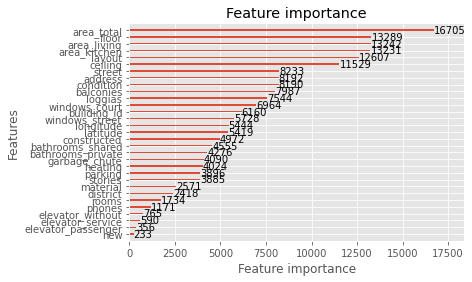

In [ ]:
from sklearn.model_selection import train_test_split
from moscow_housing.display_data import import_data
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import lightgbm as lgb
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from moscow_housing.display_data import import_data

import matplotlib.pylab as plt
plt.style.use('ggplot')

#import the data and test data, set y values for both sets
data, data_test = import_data()
Y_train = data.price
Y_test = prediction

#get the test id for later  and remove seller and test id
test_id = data_test.id

#add the price to the test set
data_test['price'] = Y_test

#combine the two datasets
combined_data = [data,data_test]
combined_data = pd.concat(combined_data)
combined_data = combined_data.drop(columns=['seller','id','price'])

#remove street and adress as iterativeimputer struggels with this
street_address = combined_data[['street','address']]
combined_data = combined_data.drop(columns=['street','address'])


#train imperative imputer and predict missing values
impe = IterativeImputer(verbose=2, random_state=5)
transformed_combined_data = impe.fit_transform(combined_data)

#turn into a pandas dataframe again add street and address and remove price
combined_data = pd.DataFrame(transformed_combined_data,columns=combined_data.columns)

#split dataset correct
data_train = combined_data.iloc[:len(Y_train),:]
data_test = combined_data.iloc[len(Y_train):,:]

data_train[['street','address']]= street_address.iloc[:len(Y_train),:].to_numpy()
data_test[['street','address']]= street_address.iloc[len(Y_train):,:].to_numpy()

data_train.info()
data_test.info()
street_address.info()

#turn categorical features into correct type
def categorical(dataset):
    for column in dataset.columns:
        column_type = dataset[column].dtype
        if column_type == 'object':
            dataset[column] = dataset[column].astype('category')

categorical(data_train)
categorical(data_test)

lightGBM_model = lgb.LGBMRegressor(
    num_leaves=20,
    max_depth=15,
    random_state=42,
    silent=True,
    metric='mse',
    n_jobs=4,
    n_estimators=10000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.09)

lightGBM_model.fit(data_train,Y_train)
prediction = lightGBM_model.predict(data_test)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        prediction[count] = prediction.mean()
    count += 1

submission = pd.DataFrame()
submission['id'] = test_id
submission['price_prediction'] = prediction

submission.to_csv('submission_lightGBM_3.csv', index= False)
